# Import and Read

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import joblib

## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [3]:
path = 'sales_predictions_2023.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Train Test Split

In [5]:
target = 'Item_Outlet_Sales'
drop_cols = ['Item_Identifier']

y = df[target].copy()
X = df.drop(columns=[target]+drop_cols,axis = 1).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


# Preprocessing/Column Transformer

In [6]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [7]:
## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [8]:
## make pipelines for categorical & numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',fill_value='missing'),
                        OneHotEncoder(drop='first', sparse=False))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [9]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000025311932220>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000025311932A90>)],
                  verbose_feature_names_out=False)

In [10]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Regular',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_Medium', 'Outlet_Size_Small', 'Outlet_Size_missing',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_

In [11]:
# preprocessed DataFrame for our train set
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_missing,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.35,0.029565,256.4646,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7510,15.25,0.000000,179.7660,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,12.35,0.158716,157.2946,1999.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# preprocessed DataFrame for our test set
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_missing,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,14.30,0.026300,79.4302,1987.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2957,7.93,0.071136,42.7086,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,14.50,0.041313,42.0454,1999.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
## confirm the first 3 rows index in y_test matches X_test_df
y_test.head(3)

7503    1743.0644
2957     356.8688
7031     377.5086
Name: Item_Outlet_Sales, dtype: float64

# Linear Regression

In [14]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [15]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [16]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.10
Test Data:	R^2= 0.57	RMSE= 1092.86


In [17]:
lin_reg.coef_

array([  -1.94181707, -423.39017971,   15.72092418,  -10.74046984,
         62.6252336 ,  -28.64831812,   45.36106369,   27.51619423,
       -106.33501436,   -1.7706262 ,   45.7540295 ,   13.89489912,
         27.02541373,    5.50974637,  -11.86488664,  -26.81372575,
        327.50113616,  -21.93239257,  -39.48573523,   42.08886467,
        232.81837736,  436.84498243,  182.12508475, -642.01571839,
        907.23913042,  -16.00005806,  241.59423372,  424.25963679,
       -382.93168631,  706.43252886, -233.75613966, -705.49476657,
        662.43915809,  -61.75139018,  936.58548593,  182.12508475,
        907.23913042])

In [18]:
## Checking the number of coeffs matches the # of feature names
print(len(lin_reg.coef_))
len(feature_names)

37


37

In [19]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= feature_names)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                           -1.941817
Item_Visibility                     -423.390180
Item_MRP                              15.720924
Outlet_Establishment_Year            -10.740470
Item_Fat_Content_Regular              62.625234
Item_Type_Breads                     -28.648318
Item_Type_Breakfast                   45.361064
Item_Type_Canned                      27.516194
Item_Type_Dairy                     -106.335014
Item_Type_Frozen Foods                -1.770626
Item_Type_Fruits and Vegetables       45.754029
Item_Type_Hard Drinks                 13.894899
Item_Type_Health and Hygiene          27.025414
Item_Type_Household                    5.509746
Item_Type_Meat                       -11.864887
Item_Type_Others                     -26.813726
Item_Type_Seafood                    327.501136
Item_Type_Snack Foods                -21.932393
Item_Type_Soft Drinks                -39.485735
Item_Type_Starchy Foods               42.088865
Outlet_Identifier_OUT013             232

In [20]:
for col in cat_sel(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Identifier:
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

For Outlet_Size:
['Medium' nan 'High' 'Small']

For Outlet_Location_Type:
['Tier 1' 'Tier 3' 'Tier 2']

For Outlet_Type:
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [21]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Outlet_Size_missing                 -705.494767
Outlet_Identifier_OUT019            -642.015718
Item_Visibility                     -423.390180
Outlet_Identifier_OUT049            -382.931686
Outlet_Size_Small                   -233.756140
Item_Type_Dairy                     -106.335014
Outlet_Location_Type_Tier 3          -61.751390
Item_Type_Soft Drinks                -39.485735
Item_Type_Breads                     -28.648318
Item_Type_Others                     -26.813726
Item_Type_Snack Foods                -21.932393
Outlet_Identifier_OUT035             -16.000058
Item_Type_Meat                       -11.864887
Outlet_Establishment_Year            -10.740470
Item_Weight                           -1.941817
Item_Type_Frozen Foods                -1.770626
Item_Type_Household                    5.509746
Item_Type_Hard Drinks                 13.894899
Item_MRP                              15.720924
Item_Type_Health and Hygiene          27.025414
Item_Type_Canned                      27

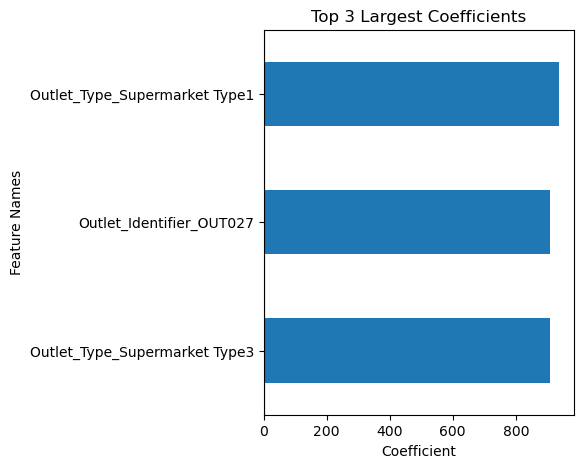

In [22]:
## Testing our function with intercept=True
ax = plot_coeffs(coeffs,top_n=3)

In [23]:
## using the ax to get the fig
fig_ax = ax.get_figure()

In [24]:
#in inches and dots per inch
# width = 8
# height = 6 
# dpi = 100  
# fig_ax.set_size_inches(width, height)
fig_ax.savefig('linreg_top3.png', bbox_inches='tight')

# Tree-Based

In [25]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [26]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [27]:
## fitting a linear regression model
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 429.06
Test Data:	R^2= 0.55	RMSE= 1110.34


In [28]:
reg.feature_importances_

array([0.05662671, 0.10065457, 0.44382841, 0.03735077, 0.00915366,
       0.00259385, 0.00263284, 0.00433469, 0.00634155, 0.00617037,
       0.00799777, 0.00304766, 0.00416576, 0.00687809, 0.00363973,
       0.0017173 , 0.00188014, 0.00839532, 0.0055234 , 0.00354573,
       0.00227145, 0.00238422, 0.0149867 , 0.00168579, 0.05737303,
       0.00392438, 0.00431946, 0.00448911, 0.00259613, 0.01837883,
       0.00433575, 0.00356475, 0.00233608, 0.00205572, 0.09295423,
       0.01166208, 0.05420398])

In [29]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

37
37


True

In [30]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                        0.056627
Item_Visibility                    0.100655
Item_MRP                           0.443828
Outlet_Establishment_Year          0.037351
Item_Fat_Content_Regular           0.009154
Item_Type_Breads                   0.002594
Item_Type_Breakfast                0.002633
Item_Type_Canned                   0.004335
Item_Type_Dairy                    0.006342
Item_Type_Frozen Foods             0.006170
Item_Type_Fruits and Vegetables    0.007998
Item_Type_Hard Drinks              0.003048
Item_Type_Health and Hygiene       0.004166
Item_Type_Household                0.006878
Item_Type_Meat                     0.003640
Item_Type_Others                   0.001717
Item_Type_Seafood                  0.001880
Item_Type_Snack Foods              0.008395
Item_Type_Soft Drinks              0.005523
Item_Type_Starchy Foods            0.003546
Outlet_Identifier_OUT013           0.002271
Outlet_Identifier_OUT017           0.002384
Outlet_Identifier_OUT018        

In [31]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
sorted_importance

Outlet_Identifier_OUT019           0.001686
Item_Type_Others                   0.001717
Item_Type_Seafood                  0.001880
Outlet_Location_Type_Tier 3        0.002056
Outlet_Identifier_OUT013           0.002271
Outlet_Location_Type_Tier 2        0.002336
Outlet_Identifier_OUT017           0.002384
Item_Type_Breads                   0.002594
Outlet_Identifier_OUT049           0.002596
Item_Type_Breakfast                0.002633
Item_Type_Hard Drinks              0.003048
Item_Type_Starchy Foods            0.003546
Outlet_Size_missing                0.003565
Item_Type_Meat                     0.003640
Outlet_Identifier_OUT035           0.003924
Item_Type_Health and Hygiene       0.004166
Outlet_Identifier_OUT045           0.004319
Item_Type_Canned                   0.004335
Outlet_Size_Small                  0.004336
Outlet_Identifier_OUT046           0.004489
Item_Type_Soft Drinks              0.005523
Item_Type_Frozen Foods             0.006170
Item_Type_Dairy                 

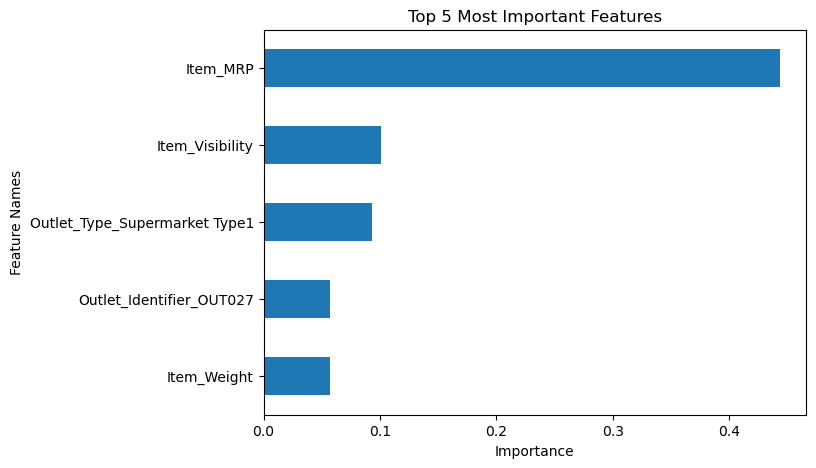

In [32]:
## just keep the top n importances and plot (that are now at the bottom of our series)
n=5
ax = sorted_importance.tail(n).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title=f'Top {n} Most Important Features');



In [33]:
## using the ax to get the fig
fig_ax = ax.get_figure()

In [34]:
#in inches and dots per inch
# width = 8
# height = 6 
# dpi = 100  
# fig_ax.set_size_inches(width, height)
fig_ax.savefig(f'rf_top{n}.png', bbox_inches='tight')

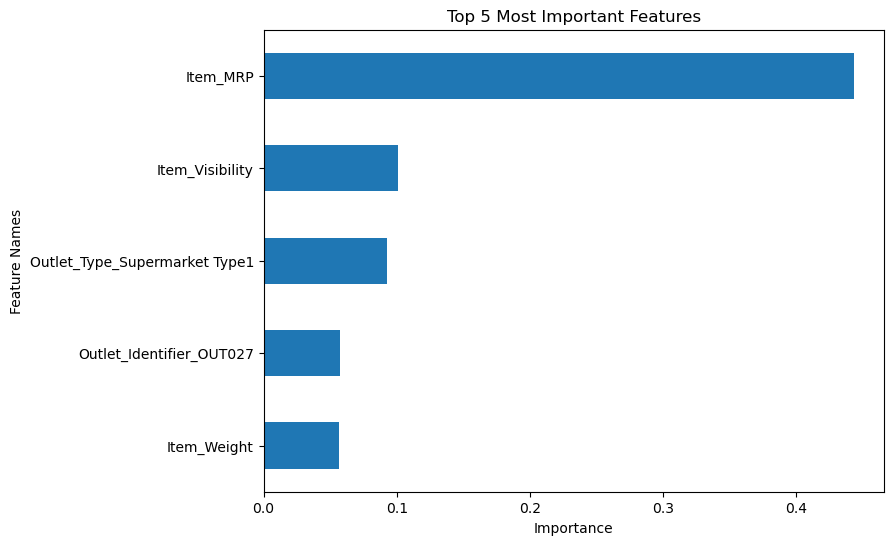

In [35]:
## testing our functions
n=5
importances = get_importances(reg,sort=True,ascending=False,
                              name=f"top {n} RandomForest Importances")
plot_importance(importances,top_n=n);

# Serialize

In [36]:
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForestRegressor':reg,
         'LinearRegression':lin_reg}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']